<a href="https://colab.research.google.com/github/amazzoli/Quantitative_immunology/blob/main/notebooks/VDJ_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Modeling a toy VDJ recombination

To understand the key ideas of how the real VDJ recombination is modeled, here we invent an extremely simplify process inspired by it (see figure below).
We just consider four "genes" that can be randomly selected with given probabilities and a deletion event that erases some nucleotides from the right end (in a simalr way of the selection and deletion of V genes).

The notebook is divided into three parts:
1. The first section defines the rules for the toy model
2. Then we generate some artificial data from our toy model and we see the concept of probabilistic scenario giving rise to a sequence.
3. Finally, we fit our probabilistic model over the generated data trying to recover the original parameters we used in part 1.

VDJ_exercise.svg

## 1 - Creating the dataset by simulating the toy VDJ recombination

First, we list which are the possible V genes of our system. Note that they are not plausible V genes, since a gene has to be composed by a number of nucleotides divisible by 3.
Real genes are also much longer and V genes are of the order of 300 nucleotides.
However, here we are not interested in biology, but only in uderstanding how to model a probabilitic process of this kind and to fit it with the expectation-maximization algorithm.

In [2]:
V_list = [
    'TCG',
    'TCA',
    'TCAA',
    'CCGA'
]

We imagine that a recombination process selects each of these genes with a heterogeneous probability. 
We choose, without a particular reason, an exponential probability.

In [3]:
p_V_dist = np.exp(np.arange(len(V_list)) / 3)
p_V_dist /= p_V_dist.sum() # normalization

<Axes: ylabel='V gene sampling probability'>

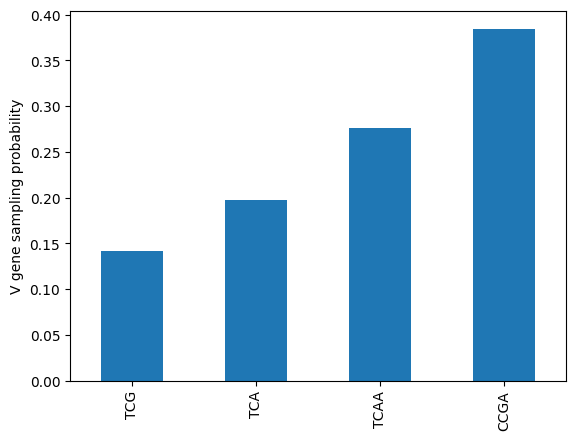

In [4]:
# Dictionary containing the probabilities for each gene
p_V_true = {V_list[i] : p_V_dist[i]  for i in range(len(V_list))}

plt.ylabel('V gene sampling probability')
pd.Series(p_V_true).plot(kind='bar')

We also consider random deletions conditioned to the V gene. We consider only probability of deleting 0, 1 or 2 genes.

In [5]:
# Probabilities are created randomly. To make this notebook perfectly reproducible
# we fix a random seed
np.random.seed(2)

# Below we build a matrix containing the three deletion probabilities for the four 
# V genes. Each row corresponds to a gene and the three elements are the 
# deletion prob. of 0, 1, and 2 nucleotides 
del_probabilities = []
for V in V_list:
  # The three deletion probs are randomly generated by sampling a multinomial
  dels = np.random.multinomial(100, [0.45, 0.30, 0.15]) / 100
  del_probabilities.append([dels[0], dels[1], dels[2]])

# This matrix is used to generate a pandas dataframe, which is the typical tool
# to manage tables of data in python. The result is printed below the cell
p_delV_true = pd.DataFrame(del_probabilities, columns=['0 del', '1 del', '2 del'])
p_delV_true.index = V_list
p_delV_true

,0 del,1 del,2 del
TCG,0.53,0.25,0.22
TCA,0.50,0.29,0.21
TCAA,0.44,0.33,0.23
CCGA,0.45,0.30,0.25


Text(0, 0.5, 'deletion probability conditioned to V gene')

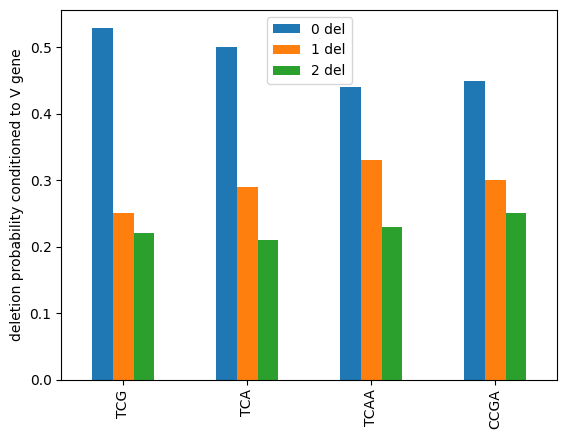

In [6]:
p_delV_true.plot(kind='bar')
plt.ylabel('deletion probability conditioned to V gene')

The two created objects: `p_V_true` and `p_delV_true` contains the true parameters of our model.
Those are the numbers that we want to infer later on.
Before, we need to generate "data" from these probabilities.



## 2 - Generating the data

We want to generate `n_seqs` "mature receptors" from recombination events governed by the probabilities set before.

We have to do `n_seqs` times the following actions:
- Extract a V gene according to `p_V_true`.
- Delete from its right side n letters, where n is extracted from `p_delV_true`, by choosing the line of the matrix according to the V gene extracted before.

Doing these operation for large `n_seqs` can be very time consuming, especially using python. 
Therefore, we exploit some simple properties of the stochastic theory and, instead of generating each sequence one by one, we generate the **counts** for each possible sequence.

For example, choosing one of the four V gene is the same problem of extracting balls of four different colors with replacement N times.
The slow way to get the numbers of balls of each color is to perform the N extractions and then count the balls.
But this numbers can be equivalently generated by a multinomial distribution:

\begin{equation}
P(n_1, n_2, \ldots, n_k) = \frac{N!}{n_1!n_2!\ldots n_k!} p_1^{n_1} p_2^{n_2} \ldots p_k^{n_k} ,
\end{equation}
where $k$ is the number of colors and $p$ the probability of extracting the ball of one color.

Luckily, we have a numpy function that generate array of numbers following the multinomial distribution: `np.random.multinomial(N, [p1, p2, ..., pk])`.

\

Below we wrote a function to generate the sequences by following those steps:

1. Sample the V genes according to the probabilities of `p_V_true`. The number of each gene generated by this process can be obtained from a multinomial sampling of `n_seqs` with `p_V_true` probabilities. This gives us an array of four numbers $(n_1, n_2, n_3, n_4)$.

2. We iterate over the four genes. For the gene $i$ we have $n_i$ exctaction and now we delete a given number of letters for its right end.
These numbers are generated with a multinomial sampling of $n_i$ objects having `p_delV_true[i]` probabilities.

3. The function returns the list of possible sequences that our process can generate with the respective counts.

In [7]:
def generate_data(p_V_true, p_delV_true, n_seqs):

  V_p_dist = list(p_V_true.values())
  V_values = list(p_V_true.keys())

  # Generating the number of V genes through multinomial sampling
  V_sample_counts = np.random.multinomial(n_seqs, V_p_dist)

  # seqs will contain all the possible sequences that can be generated through
  # this process, seqs_count the number of instances of the corresponding sequence
  seqs, seqs_count = [], []
  # For each V gene generated we extract the number of deletions that it undergoes
  for Vi in range(len(V_sample_counts)):

    V = V_values[Vi]
    del_p_dist = list(p_delV_true.loc[V].values)
    # The number of 0,1,2 deletions are again a multinomial sampling of
    # the number of sampled V genes with the deletion probs
    del_V_counts = np.random.multinomial(V_sample_counts[Vi], del_p_dist)

    for i in range(len(del_p_dist)):
      if del_V_counts[i] > 0:
        seqs.append(V[:len(V) - i])
        seqs_count.append(del_V_counts[i])

  return pd.Series(seqs_count, index=seqs).groupby(level=0).agg(sum)

In [32]:
N = 5000
data_seqs = generate_data(p_V_true, p_delV_true, N)

In [33]:
data_seqs

CC      474
CCG     583
CCGA    883
T       363
TC      810
TCA     916
TCAA    592
TCG     379
dtype: int64

We have to imagine that the list of sequences and counts above are the outcome of our experiments.
Our aim is to infer the probabilities of sampling a V gene and deleting nucleotides from these numbers.

Notice that there is one feature of those sequences that makes this problem quite non-trivial. Some generated sequences can be generated by multiple **scenarios**. For example, *TCA* can be generated by choosing the V gene *TCA* and not deleting anything or choosing *TCAA* and deleting one letter.

For later it is useful to enumerate all the possible scenarios that can lead to our sequences.


In [34]:
seqs, scenarios = [], []
for iV, V in enumerate(V_list):
  for d in [0,1,2]:
    seqs.append(V[:len(V)-d])
    scenarios.append([iV+1, d])

scenarios = pd.DataFrame(scenarios, columns=['V index', 'deletions'])
scenarios['sequence'] = seqs
scenarios.index.name = 'scenario id'

The `scenarios` table is composed by the following columns:
- Index of the scenario
- Choosen V-gene
- Number of deletions from the V-gene
- Generated sequence 

In [35]:
scenarios

,V index,deletions,sequence
scenario id,,,
0,1,0,TCG
1,1,1,TC
2,1,2,T
3,2,0,TCA
4,2,1,TC
5,2,2,T
6,3,0,TCAA
7,3,1,TCA
8,3,2,TC


It is useful for later to create a map between each unique sequence and the list of scenarios that can generate it

In [36]:
seq_to_scenarios = scenarios.reset_index()
seq_to_scenarios = seq_to_scenarios.groupby('sequence').agg(list)

In [37]:
seq_to_scenarios

,scenario id,V index,deletions
sequence,,,
CC,[11],[4],[2]
CCG,[10],[4],[1]
CCGA,[9],[4],[0]
T,"[2, 5]","[1, 2]","[2, 2]"
TC,"[1, 4, 8]","[1, 2, 3]","[1, 1, 2]"
TCA,"[3, 7]","[2, 3]","[0, 1]"
TCAA,[6],[3],[0]
TCG,[0],[1],[0]


## 3 - Maximum likelihood inference

The problem that we have to solve now is the following.
Imagine that you have a sample of sequences as the one generated above and you also know that they are generated by choosing a V gene and deleting some nucleotides from its right end.
What are the V-gene picking and deletion probabilities?

We use the maximization of the log-likelihood of observing our samples.
If we call $\vec{x} = \lbrace x_1, \ldots, x_N \rbrace$ the sequences, the log likelihood of generaing those under a model parametrized by $\vec{\theta}$ is
\begin{equation}
\mathcal{L}(\vec{x}, \vec{\theta}) = \sum_{i=1}^N \log P(x_i|\vec{\theta}),
\end{equation}
where the samples are assumed to be independent and $P(x_i|\vec{\theta})$ is the probability of generating a single sequence.
In our case the parameters $\theta$ are:
\begin{equation}
\theta = \lbrace P(V_i) \rbrace_{i=1,2,3} \cup \lbrace P(k|V_i) \rbrace_{i=1,2,3,4; \; k=0,1},
\end{equation}
where the first three parameters are the probability of choosing the respective V gene and $p(V_4)$ is obtained from normalization.
Then we have, for each V gene, two parameters for the deletion of $0$ or $1$ nucleotide ($p(2 | V_i)$ is given by normalization).
Therefore we have a total of 11 parameters.

The parameters and the likelihood are connected by the fact that each sequence can be generated from a given set of scenarios (given by the table above) and that we know the probabilities of the scenarios.
We use the notation $s$ to indicate a specific scenario, which, more precisely, is defined as a pair $s = (V_i, k)$ of the V gene $V_i$ with $k$ deletions.
Moreover we indicate with $\mathcal{S}(x)$ the list of scenarios that lead to the sequence $x$.
\begin{equation}
P(x_i|\vec{\theta}) = \sum_{s \in \mathcal{S}(x)} P(s|\vec{\theta}) = \sum_{(V_i, k) \in \mathcal{S}(x)} P(V_i) P(k | V_i).
\end{equation}
$P(V_i)$ and $P(k | V_i)$ can be directly read from the parameter list $\theta$.
For example, the sequence $x = T$ have probability $P('T') = P(V_1) * P(2 | V_1) + P(V_2) * P(2 | V_2)$.

Below we write a function that evaluates the log-likelihood of the dataset, `seqs`, given the model parameter, `p_V_guess`, `p_del_guess`.

In [38]:
def log_likelihood(seqs, p_V, p_delV, seq_to_scenarios):
  ll = 0
  for s, c in seqs.items():
    scenes = seq_to_scenarios.loc[s]
    p_seq = 0
    for i in range(len(scenes['scenario id'])):
      iV, id = scenes['V index'][i]-1, scenes['deletions'][i]
      p_seq += p_V[iV] * p_delV[iV][id]
    ll += c * np.log(p_seq)
  return ll

# Evaluating the likelihood of uniform guesses of the paramters (all equal for 
# all V genes and deletions)
p_V_rand = np.ones(len(V_list)) / len(V_list)
p_delV_rand = np.ones((len(V_list), 3)) / 3
rand_like = log_likelihood(data_seqs, p_V_rand, p_delV_rand, seq_to_scenarios)
print('Likelyhood of uniform guesses', rand_like)


# Evaluating the likelihood of the true parameters
p_V_true_l = list(p_V_true.values())
p_delV_true_l = p_delV_true.to_numpy()
true_like = log_likelihood(data_seqs, p_V_true_l, p_delV_true_l, seq_to_scenarios)
print('"Maximum" likelihood of true parameters', true_like)

Likelyhood of uniform guesses -10648.122051182661
"Maximum" likelihood of true parameters -10124.033628382405


Of course we do not know the true values of the parameters and we want to recover them in our inference scheme that aims to maximixe the likelihood.



The maximization algorithm that we will use exploits the structure of our problem: we can identify a set of "observed" variables, that are the sequences $\vec{x}$, and "latent" or "hidden" variables that are the scenarios, $\vec{s}$.
The algorithm is called **expectation-maximization**.
The general idea is that we start from a guess of the parameters and a *pseudo-likelihood* is computed using the estimates of the guessed parameters (expectation) and the parameters are then updated by maximizing this pseudo-likelihood (maximization).
At the next iteration one uses those new estimates as initial guesses and repeats the two steps.
This procedure reaches a fixed point that is an optimum of the original likelihood.
The advantage of this procedure is that it is much easier to perform the optimization step on the pseudo-likelihood than the original one, speeding up the overall computation.


In practice this algorithm translates in the quite simple steps shown below.
Their derivation and the proof that they maximize the likelihood is discussed in the lecture notes.

- Choose an intial guess for $P^{(0)}(V_i)$ and $P^{(0)}(k|V_i)$. We will use uniform probabilities.
- Iterate over $k=1, 2, \ldots$ until convergence:
> - given the parameters at the step $k-1$, 
\begin{equation}
\theta^{(k-1)} = \lbrace P^{(k-1)}(V_i) \rbrace_{i=1,2,3} \cup \lbrace P^{(k-1)}(k|V_i) \rbrace_{i=1,2,3,4; \; k=0,1} ,
\end{equation}
compute the probability of each possible scenario that can generate our sequences
\begin{equation}
P(s|\theta^{(k-1)}) = P((V_i, k)|\theta^{(k-1)}) = P^{(k-1)}(V_i) P^{(k-1)}(k|V_i)
\end{equation}
> - For each unique sequence $x$, compute the probability of generating the sequence
\begin{equation}
P(x|\theta^{(k-1)}) = \sum_{s \in \mathcal{S}(x)} P(s|\theta^{(k-1)})
\end{equation}
>- Update the parameters as an average computed with respect to $\theta^{(k-1)}$.
\begin{equation}
P^{(k)}(V_i) = \sum_x \frac{n_x}{N} \sum_{(V_j, k) \in \mathcal{S}(x)} \delta_{V_i, V_j} \frac{P((V_i, k)|\theta^{(k-1)})}{P(x|\theta^{(k-1)})}
\end{equation}
\begin{equation}
P^{(k)}(k|V_i) = \frac{1}{P^{(k)}(V_i)} \sum_x \frac{n_x}{N} \sum_{(V_j, l) \in \mathcal{S}(x)} \delta_{V_i, V_j} \delta_{k, l} \frac{P((V_i, k)|\theta^{(k-1)})}{P(x|\theta^{(k-1)})}
\end{equation}
>- Compute some measure of distance between the parameters at step $k$ and at $k-1$. If the distance is smaller than a threshold, stop the iteration.

In [39]:
def EM_step(p_V_guess, p_delV_guess, seqs, scenarios, seq_to_scenarios):
  """
  Single step of the Expectation-Maximization algorithm.
  """

  N_tot = seqs.sum()

  # Building the scenario probabilities
  p_scenarios = np.zeros(len(scenarios))
  for i, scenario in scenarios.iterrows():
    iV = scenario['V index'] - 1
    k = scenario['deletions']
    p_scenarios[i] = p_V_guess[iV] * p_delV_guess[iV][k]

  # Building the probability of generating a sequence
  p_seqs = dict()
  for s, scenarios_of_s in seq_to_scenarios.iterrows():
    p_seqs[s] = 0
    for i in scenarios_of_s['scenario id']:
      p_seqs[s] += p_scenarios[i]

  # Updating the parameters
  p_V_new, p_delV_new = np.zeros(len(p_V_guess)), np.zeros((len(p_V_guess), len(p_delV_guess[0])))
  for s, scenarios_of_s in seq_to_scenarios.iterrows():
    nx = seqs.loc[s]
    px = p_seqs[s]
    for i in range(len(scenarios_of_s['scenario id'])):
      iV = scenarios_of_s['V index'][i] - 1
      k = scenarios_of_s['deletions'][i]
      i_scen = scenarios_of_s['scenario id'][i]
      p_V_new[iV] += nx * p_scenarios[i_scen] / px
      p_delV_new[iV][k] += nx * p_scenarios[i_scen] / px
  # Renormalizing
  p_V_new /= N_tot
  p_delV_new /= (p_V_new[:,np.newaxis] * N_tot)

  return p_V_new, p_delV_new

In [40]:
# Uniform initial guesses
p_V_guess = np.ones(len(V_list)) / len(V_list)
p_delV_guess = np.ones((len(V_list), 3)) / 3

for i in range(10):

  # EM_step that recomputes the parameters
  p_V_new, p_delV_new = EM_step(p_V_guess, p_delV_guess, data_seqs, scenarios, seq_to_scenarios)
  
  # Quadratic distance between the probabilities of P_V
  delta = np.sqrt(np.sum((p_V_new - p_V_guess)**2))
  print('iteration %i, delta='%i, delta)
  if delta < 1e-6: # Break at convergence
    break  
  
  p_V_guess, p_delV_guess = np.copy(p_V_new), np.copy(p_delV_new)

iteration 0, delta= 0.1758317946220194
iteration 1, delta= 2.7755575615628914e-17


The algorithm should converge in a couple of iterations, leading to our inferred set of parameters `p_V_new` and `p_delV_new`.

Error: 0.013776313440874481


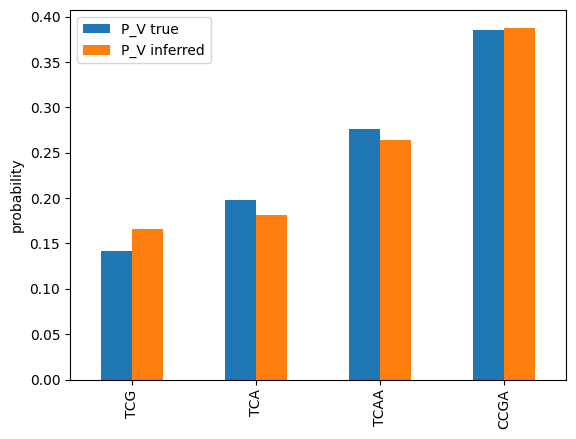

In [41]:
s_true = pd.Series(p_V_true, name='P_V true')
s_guess = pd.Series(p_V_new, V_list, name='P_V inferred')
frame_compare = pd.merge(s_true, s_guess, left_index=True, right_index=True)
frame_compare['delta'] = np.abs(frame_compare['P_V true'] - frame_compare['P_V inferred']) / len(frame_compare)
print('Error:', np.sum(frame_compare['delta']))

frame_compare[['P_V true', 'P_V inferred']].plot(kind='bar')
plt.ylabel('probability')

plt.savefig('P_V_indeferece_comparison.svg')

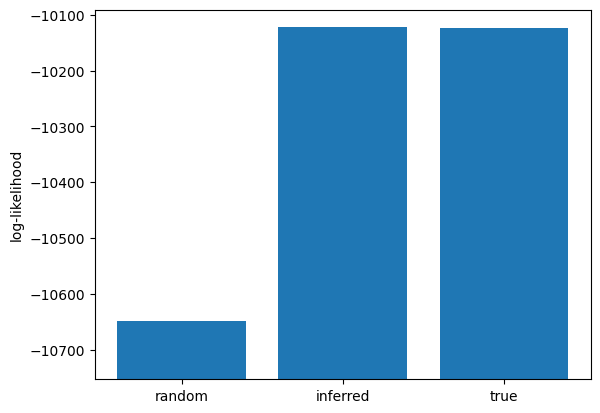

In [42]:
plt.ylabel('log-likelihood')
offs = rand_like - (true_like - rand_like)/5
guess_like = log_likelihood(data_seqs, p_V_new, p_delV_new, seq_to_scenarios)
likes = np.array([rand_like, guess_like, true_like])
plt.bar([0,1,2], likes - offs, tick_label=['random', 'inferred', 'true'], bottom = offs)

plt.savefig('likelihood_comparison.svg')

### Exercises
1 - Visualize also the differences between the guesses and real estimates of deletion probabilities.

2 - Try the algorithm with different initial conditions than the random guesses. Try also with larger numbers $N$ of the samples. How the difference with the true parameters change? 